# Model training

This script performs the model training of the Coco dataset.

It loads the pre-processed data from the directory, build the model network, train it.

In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
class COCOSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory containing images.
            mask_dir (str): Path to the directory containing instance masks.
            transform (callable, optional): Optional transform to be applied to images.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".jpg")])

    def __len__(self):
        return len(self.mask_files)

    def __getitem__(self, idx):
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_dir, mask_name)
        image_name = mask_name.split('_')[0] + ".jpg" # get image name from mask name by removing _1, _2 etc
        image_path = os.path.join(self.image_dir, image_name)

        if not mask_name:
            return None  # No mask found, handle accordingly
        
        # Load image
        image_original = cv2.imread(image_path)
        image_resized = cv2.resize(image_original, (500, 500))
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image_normalized = image_rgb.astype(np.float32) / 255.0  # Normalize

        mask_original = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        image_resized = cv2.resize(mask_original, (500, 500))

        #cv2.imshow('image', image_original)
        #cv2.waitKey(5000)
        #cv2.destroyAllWindows()

        #cv2.imshow('image', mask_original)
        #cv2.waitKey(5000)
        #cv2.destroyAllWindows()

        # Convert to tensors
        image_tensor = torch.tensor(image_normalized, dtype=torch.float32).permute(2, 0, 1)  # Shape (C, H, W)
        mask_tensor = torch.tensor(image_resized, dtype=torch.uint8)  # Shape (num_instances, H, W)

        return image_tensor, mask_tensor


In [3]:
image_val_dir = "/home/maver02/Development/Datasets/COCO/preprocessed_v2/val/images"
mask_val_dir = "/home/maver02/Development/Datasets/COCO/preprocessed_v2/val/masks"
image_train_dir = "/home/maver02/Development/Datasets/COCO/preprocessed_v2/train/images"
masks_train_dir = "/home/maver02/Development/Datasets/COCO/preprocessed_v2/train/masks"

In [4]:
test_data = COCOSegmentationDataset(image_val_dir, mask_val_dir)

In [5]:
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 500, 500])
Labels batch shape: torch.Size([64, 500, 500])


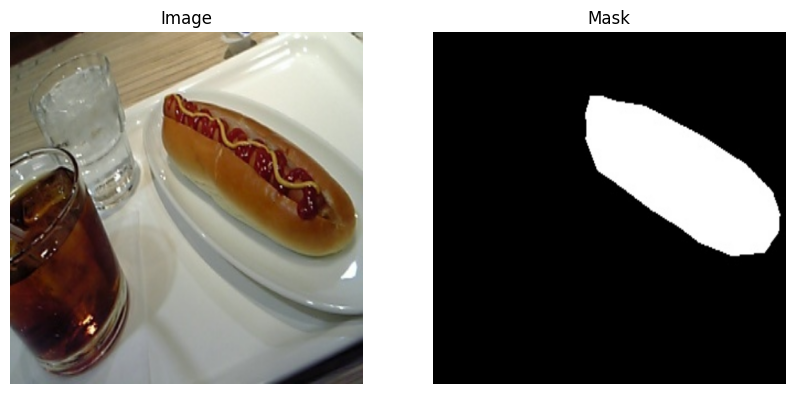

In [6]:
# Display image and label.
test_features, test_masks = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_masks.size()}")
image = test_features[0].squeeze()
#img_reshaped = np.reshape(img, (600, 400,3 ))
mask = test_masks[0]

# Convert image from (3, H, W) to (H, W, 3)
image_np = image.permute(1, 2, 0).numpy()

# Plot image and mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_np)  # Now correctly formatted
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(0), cmap="gray")  # Convert (1, H, W) to (H, W)
plt.title("Mask")
plt.axis("off")

plt.show()